In [21]:
import pandas as pd

# Load data
dam = pd.read_csv('dam_prices.csv')
dam['datetime_utc'] = pd.to_datetime(dam['datetime_utc'])

# Basic analysis
print(f"Average price: {dam['price_eur_mwh'].mean():.2f} EUR/MWh")
print(f"Min price: {dam['price_eur_mwh'].min():.2f} EUR/MWh")
print(f"Max price: {dam['price_eur_mwh'].max():.2f} EUR/MWh")

imbalance_actual = pd.read_csv('imbalance_actual.csv')
imbalance_actual['datetime_utc'] = pd.to_datetime(imbalance_actual['datetime_utc'])

# Basic analysis
print(f"Average imbalance: {imbalance_actual['price_eur_mwh'].mean():.2f} MWh")
print(f"Min imbalance: {imbalance_actual['price_eur_mwh'].min():.2f} MWh")
print(f"Max imbalance: {imbalance_actual['price_eur_mwh'].max():.2f} MWh")

imbalance_forecast = pd.read_csv('imbalance_forecast.csv')
imbalance_forecast['datetime_utc'] = pd.to_datetime(imbalance_forecast['datetime_utc'])

# Basic analysis
print(f"Average imbalance: {imbalance_forecast['price_eur_mwh'].mean():.2f} MWh")
print(f"Min imbalance: {imbalance_forecast['price_eur_mwh'].min():.2f} MWh")
print(f"Max imbalance: {imbalance_forecast['price_eur_mwh'].max():.2f} MWh")

Average price: 75.86 EUR/MWh
Min price: -462.33 EUR/MWh
Max price: 565.46 EUR/MWh
Average imbalance: 82.25 MWh
Min imbalance: -999.00 MWh
Max imbalance: 2547.85 MWh
Average imbalance: 72.37 MWh
Min imbalance: -850.00 MWh
Max imbalance: 999.00 MWh


In [22]:
# Data Preprocessing for imbalance_forecast
print("🔍 Analyzing imbalance_forecast data gaps...")

# Check for missing values and time gaps
print(f"📊 Original data shape: {imbalance_forecast.shape}")
print(f"📊 Missing values in price_eur_mwh: {imbalance_forecast['price_eur_mwh'].isna().sum()}")
print(f"📊 Missing values in datetime_utc: {imbalance_forecast['datetime_utc'].isna().sum()}")

# Sort by datetime to ensure proper order
imbalance_forecast = imbalance_forecast.sort_values('datetime_utc').reset_index(drop=True)

# Check time continuity
print(f"📅 Time range: {imbalance_forecast['datetime_utc'].min()} to {imbalance_forecast['datetime_utc'].max()}")
print(f"📅 Expected 1-minute intervals")

# Create a complete time series with 1-minute intervals
start_time = imbalance_forecast['datetime_utc'].min()
end_time = imbalance_forecast['datetime_utc'].max()
complete_time_range = pd.date_range(start=start_time, end=end_time, freq='1min')

print(f"📊 Complete time range would have {len(complete_time_range)} minutes")
print(f"📊 Actual data has {len(imbalance_forecast)} records")
print(f"📊 Missing {len(complete_time_range) - len(imbalance_forecast)} time points")

# Create a complete dataframe with all time points
complete_df = pd.DataFrame({'datetime_utc': complete_time_range})
imbalance_forecast_complete = complete_df.merge(imbalance_forecast, on='datetime_utc', how='left')

print(f"📊 After merging: {imbalance_forecast_complete.shape}")
print(f"📊 Missing values after merge: {imbalance_forecast_complete['price_eur_mwh'].isna().sum()}")

# Function to fill missing values using day-based averaging
def fill_missing_with_day_average(df, max_days_gap=2):
    """
    Fill missing values by averaging values from surrounding days.
    If 1 day missing: average of day before and after
    If 2 days missing: average of 2 days before and 2 days after
    """
    df_filled = df.copy()
    
    # Find missing values
    missing_mask = df_filled['price_eur_mwh'].isna()
    missing_indices = df_filled[missing_mask].index.tolist()
    
    print(f"🔧 Filling {len(missing_indices)} missing values...")
    
    for idx in missing_indices:
        current_time = df_filled.loc[idx, 'datetime_utc']
        current_hour = current_time.hour
        current_minute = current_time.minute
        
        # Try different day gaps
        for days_gap in range(1, max_days_gap + 1):
            # Look for values at the same time of day, days_gap days before and after
            before_time = current_time - pd.Timedelta(days=days_gap)
            after_time = current_time + pd.Timedelta(days=days_gap)
            
            # Find values at the same time of day
            before_values = df_filled[
                (df_filled['datetime_utc'].dt.date == before_time.date()) &
                (df_filled['datetime_utc'].dt.hour == current_hour) &
                (df_filled['datetime_utc'].dt.minute == current_minute) &
                (df_filled['price_eur_mwh'].notna())
            ]['price_eur_mwh']
            
            after_values = df_filled[
                (df_filled['datetime_utc'].dt.date == after_time.date()) &
                (df_filled['datetime_utc'].dt.hour == current_hour) &
                (df_filled['datetime_utc'].dt.minute == current_minute) &
                (df_filled['price_eur_mwh'].notna())
            ]['price_eur_mwh']
            
            # If we found values from both sides, use their average
            if len(before_values) > 0 and len(after_values) > 0:
                avg_value = (before_values.iloc[0] + after_values.iloc[0]) / 2
                df_filled.loc[idx, 'price_eur_mwh'] = avg_value
                print(f"  ✅ Filled {current_time} using {days_gap}-day average: {avg_value:.2f}")
                break
            
            # If only one side has data, use that value
            elif len(before_values) > 0:
                df_filled.loc[idx, 'price_eur_mwh'] = before_values.iloc[0]
                print(f"  ✅ Filled {current_time} using {days_gap}-day before: {before_values.iloc[0]:.2f}")
                break
            elif len(after_values) > 0:
                df_filled.loc[idx, 'price_eur_mwh'] = after_values.iloc[0]
                print(f"  ✅ Filled {current_time} using {days_gap}-day after: {after_values.iloc[0]:.2f}")
                break
    
    return df_filled

# Apply the filling function
print("🔄 Filling missing values with day-based averaging...")
imbalance_forecast_filled = fill_missing_with_day_average(imbalance_forecast_complete, max_days_gap=2)

# Check remaining missing values
remaining_missing = imbalance_forecast_filled['price_eur_mwh'].isna().sum()
print(f"📊 Remaining missing values: {remaining_missing}")

# If there are still missing values, use forward/backward fill as last resort
if remaining_missing > 0:
    print("🔄 Using forward/backward fill for remaining missing values...")
    imbalance_forecast_filled['price_eur_mwh'] = imbalance_forecast_filled['price_eur_mwh'].fillna(method='ffill').fillna(method='bfill')

# Final check
final_missing = imbalance_forecast_filled['price_eur_mwh'].isna().sum()
print(f"📊 Final missing values: {final_missing}")

# Update the original dataframe
imbalance_forecast = imbalance_forecast_filled.copy()

print("✅ Data preprocessing completed!")
print(f"📊 Final data shape: {imbalance_forecast.shape}")
print(f"📊 Data completeness: {((len(imbalance_forecast) - final_missing) / len(imbalance_forecast) * 100):.1f}%")


🔍 Analyzing imbalance_forecast data gaps...
📊 Original data shape: (105949, 6)
📊 Missing values in price_eur_mwh: 0
📊 Missing values in datetime_utc: 0
📅 Time range: 2025-07-24 13:52:00 to 2025-10-20 16:36:00
📅 Expected 1-minute intervals
📊 Complete time range would have 126885 minutes
📊 Actual data has 105949 records
📊 Missing 20936 time points
📊 After merging: (126885, 6)
📊 Missing values after merge: 20936
🔄 Filling missing values with day-based averaging...
🔧 Filling 20936 missing values...
  ✅ Filled 2025-07-24 13:59:00 using 1-day after: 49.00
  ✅ Filled 2025-07-24 14:05:00 using 1-day after: 46.67
  ✅ Filled 2025-07-24 14:11:00 using 1-day after: 77.50
  ✅ Filled 2025-07-24 14:15:00 using 1-day after: 100.00
  ✅ Filled 2025-07-24 14:19:00 using 2-day after: 47.30
  ✅ Filled 2025-07-24 14:25:00 using 1-day after: 100.00
  ✅ Filled 2025-07-24 14:29:00 using 2-day after: 47.20
  ✅ Filled 2025-07-24 14:34:00 using 1-day after: 103.84
  ✅ Filled 2025-07-24 14:51:00 using 1-day after:

/var/folders/t9/408jh17d3qb_w6yf1wrm58rc0000gn/T/ipykernel_8996/2505725544.py:103: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  imbalance_forecast_filled['price_eur_mwh'] = imbalance_forecast_filled['price_eur_mwh'].fillna(method='ffill').fillna(method='bfill')


📊 Visualizing data quality...


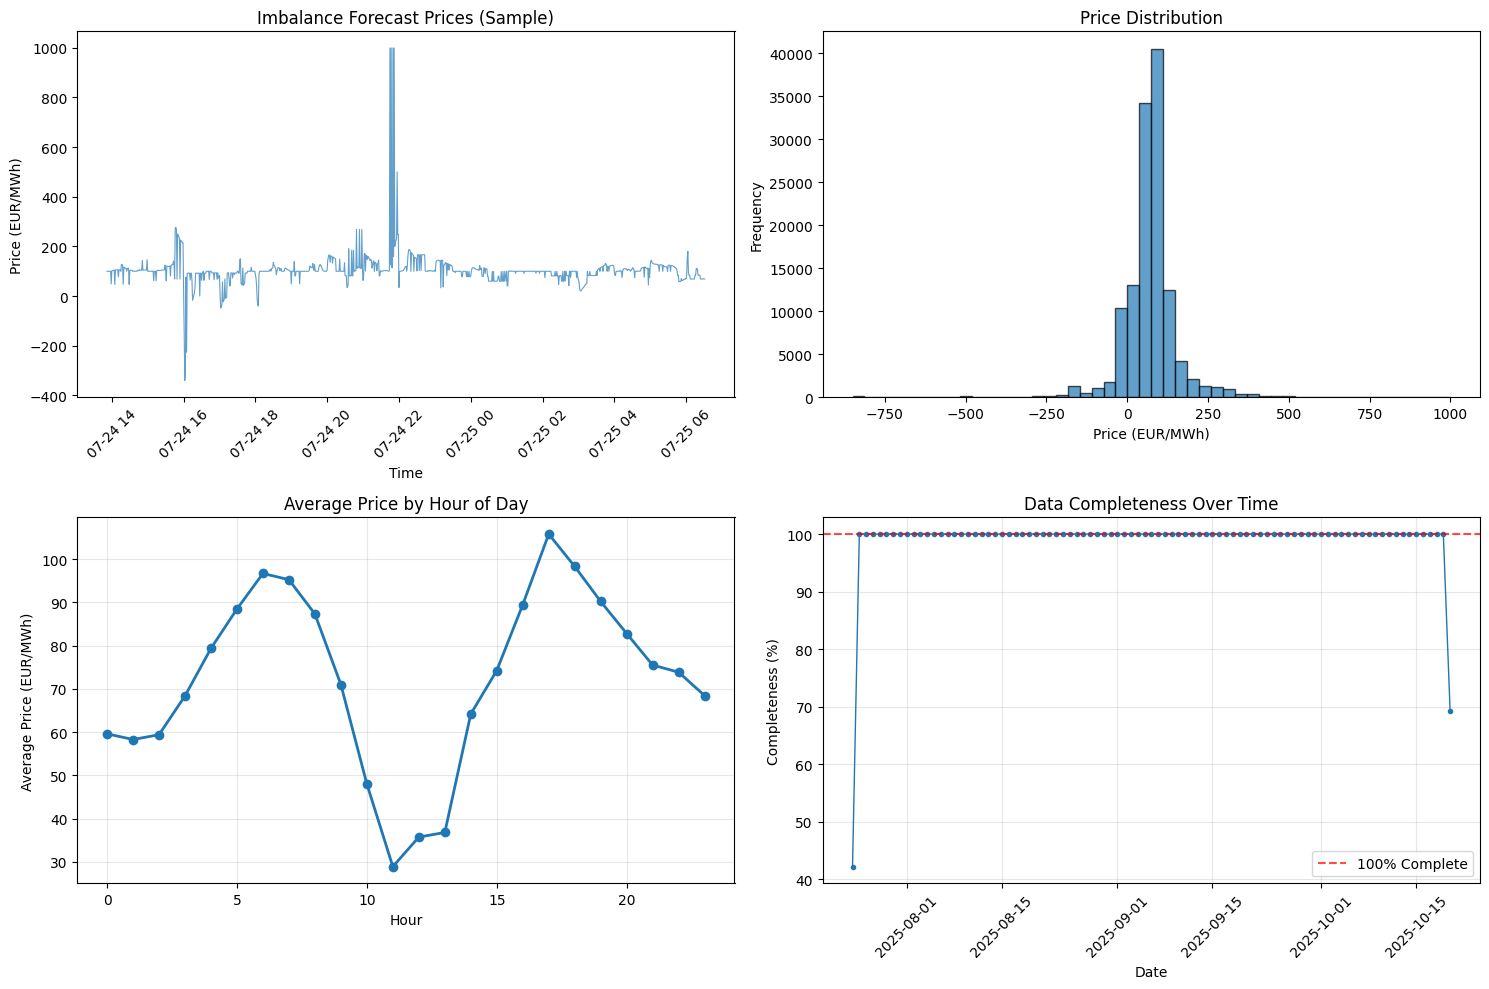

📈 Data Quality Summary:
  Total records: 126,885
  Time span: 88 days
  Price range: -850.00 to 999.00 EUR/MWh
  Mean price: 72.34 EUR/MWh
  Std price: 84.88 EUR/MWh
  Missing values: 0


In [33]:
# Visualize data quality before and after preprocessing
import matplotlib.pyplot as plt
import numpy as np

print("📊 Visualizing data quality...")

# Plot a sample of the data to show continuity
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sample 1000 points for visualization
sample_size = min(1000, len(imbalance_forecast))
sample_data = imbalance_forecast.head(sample_size)

# Plot 1: Time series of prices
axes[0, 0].plot(sample_data['datetime_utc'], sample_data['price_eur_mwh'], alpha=0.7, linewidth=0.8)
axes[0, 0].set_title('Imbalance Forecast Prices (Sample)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Price (EUR/MWh)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Price distribution
axes[0, 1].hist(imbalance_forecast['price_eur_mwh'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Price Distribution')
axes[0, 1].set_xlabel('Price (EUR/MWh)')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: Daily pattern (average by hour)
imbalance_forecast['hour'] = imbalance_forecast['datetime_utc'].dt.hour
hourly_avg = imbalance_forecast.groupby('hour')['price_eur_mwh'].mean()
axes[1, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6)
axes[1, 0].set_title('Average Price by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Average Price (EUR/MWh)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Data completeness over time
imbalance_forecast['date'] = imbalance_forecast['datetime_utc'].dt.date
daily_counts = imbalance_forecast.groupby('date').size()
expected_daily = 24 * 60  # 1440 minutes per day
completeness = (daily_counts / expected_daily) * 100

axes[1, 1].plot(daily_counts.index, completeness.values, marker='o', linewidth=1, markersize=3)
axes[1, 1].axhline(y=100, color='r', linestyle='--', alpha=0.7, label='100% Complete')
axes[1, 1].set_title('Data Completeness Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Completeness (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"📈 Data Quality Summary:")
print(f"  Total records: {len(imbalance_forecast):,}")
print(f"  Time span: {(imbalance_forecast['datetime_utc'].max() - imbalance_forecast['datetime_utc'].min()).days} days")
print(f"  Price range: {imbalance_forecast['price_eur_mwh'].min():.2f} to {imbalance_forecast['price_eur_mwh'].max():.2f} EUR/MWh")
print(f"  Mean price: {imbalance_forecast['price_eur_mwh'].mean():.2f} EUR/MWh")
print(f"  Std price: {imbalance_forecast['price_eur_mwh'].std():.2f} EUR/MWh")
print(f"  Missing values: {imbalance_forecast['price_eur_mwh'].isna().sum()}")


In [34]:
#print first 5 rows of imbalance_forecast
print(imbalance_forecast.head())
#print first 5 rows of imbalance_actual
print(imbalance_actual.head())
#print first 5 rows of dam
print(dam.head())



         datetime_utc        date  hour  minute  second  price_eur_mwh
0 2025-07-24 13:52:00  2025-07-24    13    52.0     0.0          100.0
1 2025-07-24 13:53:00  2025-07-24    13    53.0     0.0          100.0
2 2025-07-24 13:54:00  2025-07-24    13    54.0     0.0          100.0
3 2025-07-24 13:55:00  2025-07-24    13    55.0     0.0          100.0
4 2025-07-24 13:56:00  2025-07-24    13    56.0     0.0          100.0
         datetime_utc        date  hour  minute  price_eur_mwh
0 2024-05-21 22:00:00  2024-05-21    22       0         106.39
1 2024-05-21 22:15:00  2024-05-21    22      15         149.28
2 2024-05-21 22:30:00  2024-05-21    22      30         151.17
3 2024-05-21 22:45:00  2024-05-21    22      45         226.60
4 2024-05-21 23:00:00  2024-05-21    23       0         204.76
         datetime_utc        date  hour  minute  price_eur_mwh
0 2023-12-31 23:00:00  2023-12-31    23       0           0.10
1 2023-12-31 23:15:00  2023-12-31    23      15           0.10
2 2023-

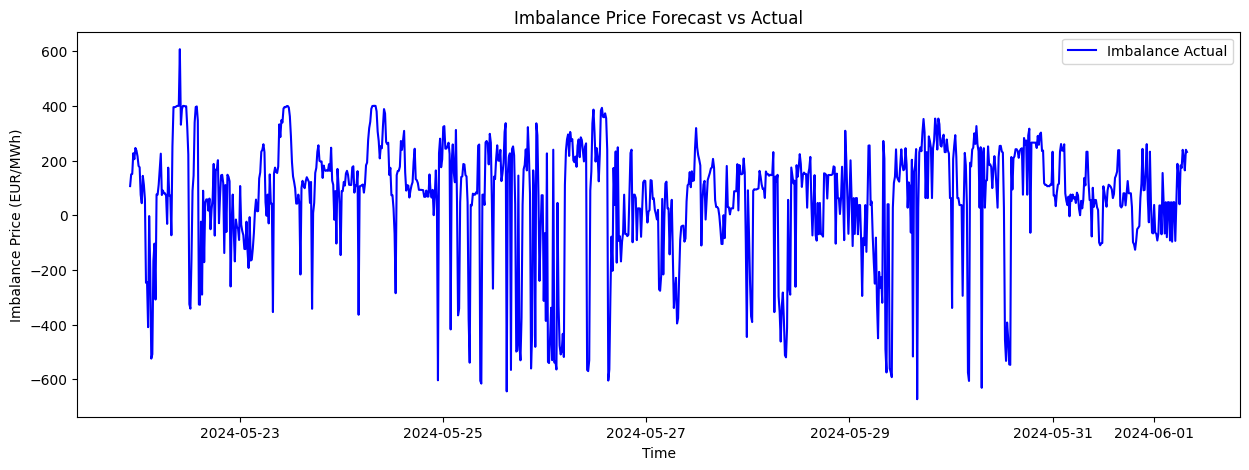

In [11]:
#plot the data
import matplotlib.pyplot as plt

# Plot imbalance actual in 2024
imbalance_actual_2024 = imbalance_actual[imbalance_actual['datetime_utc'].dt.year == 2024]
plt.figure(figsize=(15, 5))
plt.plot(imbalance_actual_2024['datetime_utc'][:1000], imbalance_actual_2024['price_eur_mwh'][:1000], label='Imbalance Actual', color='blue')
plt.xlabel('Time')
plt.ylabel('Imbalance Price (EUR/MWh)')
plt.title('Imbalance Price Forecast vs Actual')
plt.legend()
plt.show()




In [42]:
# Simple PyTorch LSTM for Imbalance Forecast with GPU Support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time

# GPU setup for Mac (Metal Performance Shaders)
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')  # Apple Silicon GPU
    else:
        return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

# Check PyTorch version and GPU capabilities
print(f"PyTorch version: {torch.__version__}")
if device.type == 'mps':
    print("✅ Metal Performance Shaders (MPS) is available for GPU acceleration on Mac")
elif device.type == 'cuda':
    print(f"✅ CUDA is available: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  Using CPU - no GPU acceleration available")


Using device: mps
PyTorch version: 2.9.0
✅ Metal Performance Shaders (MPS) is available for GPU acceleration on Mac


In [43]:
# Dataset and Transformer Model for feature-engineered sequences
class SequenceDataset(Dataset):
    def __init__(self, sequences, targets):
        """
        sequences: numpy array of shape (n_sequences, 59, n_features) - 59 timesteps with engineered features
        targets: numpy array of shape (n_sequences,) - corresponding targets
        """
        self.sequences = sequences
        self.targets = targets
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Get feature-engineered sequence (59 timesteps, n_features)
        sequence = self.sequences[idx]  # Shape: (59, n_features)
        # No reshaping needed - already in correct format for transformer
        # Get target value
        target = self.targets[idx]
        return torch.FloatTensor(sequence), torch.FloatTensor([target])

class SimpleTransformer(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2):
        super(SimpleTransformer, self).__init__()
        
        # Input projection
        self.input_projection = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1000, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output
        self.output = nn.Linear(d_model, 1)
    
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        seq_len = x.size(1)
        x = x + self.pos_encoding[:seq_len].unsqueeze(0)
        
        # Transformer
        x = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Use last time step
        x = x[:, -1, :]  # (batch, d_model)
        
        # Output
        return self.output(x)  # (batch, 1)

print("🏗️ Dataset and Transformer model classes defined!")

# Test the dataset with feature-engineered sequences
test_sequences = np.random.randn(100, 59, 15)  # 100 sequences of 59 timesteps with 15 features each
test_targets = np.random.randn(100)
test_dataset = SequenceDataset(test_sequences, test_targets)
sample_seq, sample_target = test_dataset[0]
print(f"Sample sequence shape: {sample_seq.shape}")
print(f"Sample target shape: {sample_target.shape}")
print(f"Expected sequence shape: (59, 15)")
print(f"Expected target shape: (1,)")


🏗️ Dataset and Transformer model classes defined!
Sample sequence shape: torch.Size([59, 15])
Sample target shape: torch.Size([1])
Expected sequence shape: (59, 15)
Expected target shape: (1,)


In [49]:
# Data preparation for 2-hour sequences predicting 15-minute periods
print("🔄 Preparing data for 2-hour sequences predicting 15-minute periods...")

# First, let's examine the time ranges and granularity
print("📅 Dataset time ranges:")
print(f"Imbalance Actual: {imbalance_actual['datetime_utc'].min()} to {imbalance_actual['datetime_utc'].max()}")
print(f"Imbalance Forecast: {imbalance_forecast['datetime_utc'].min()} to {imbalance_forecast['datetime_utc'].max()}")

# Check data granularity
print("🔍 Checking data granularity...")
print("Imbalance Actual sample times (should be 15-minute intervals):")
print(imbalance_actual['datetime_utc'].head(10))
print("Imbalance Forecast sample times (should be 1-minute intervals):")
print(imbalance_forecast['datetime_utc'].head(10))

# Find common time range with buffer for 2-hour sequences
# We need forecast data to start at least 2 hours before the first actual period
forecast_start = imbalance_forecast['datetime_utc'].min()
forecast_end = imbalance_forecast['datetime_utc'].max()
actual_start = imbalance_actual['datetime_utc'].min()
actual_end = imbalance_actual['datetime_utc'].max()

# Adjust actual start to allow for 1-hour forecast sequences
adjusted_actual_start = actual_start + pd.Timedelta(hours=1, minutes=1)  # Add 1 hour + 1 minute buffer

# Find the overlapping range
common_start = max(adjusted_actual_start, forecast_start)
common_end = min(actual_end, forecast_end)

print(f"📊 Original time ranges:")
print(f"  Forecast: {forecast_start} to {forecast_end}")
print(f"  Actual: {actual_start} to {actual_end}")
print(f"📊 Adjusted actual start (with 1h buffer): {adjusted_actual_start}")
print(f"📊 Common time range: {common_start} to {common_end}")

# Filter to common time range
imbalance_actual_filtered = imbalance_actual[
    (imbalance_actual['datetime_utc'] >= common_start) & 
    (imbalance_actual['datetime_utc'] <= common_end)
].copy().sort_values('datetime_utc').reset_index(drop=True)

imbalance_forecast_filtered = imbalance_forecast[
    (imbalance_forecast['datetime_utc'] >= forecast_start) & 
    (imbalance_forecast['datetime_utc'] <= common_end)
].copy().sort_values('datetime_utc').reset_index(drop=True)

print(f"📈 Filtered dataset sizes:")
print(f"  Imbalance Actual: {len(imbalance_actual_filtered)} (15-min intervals)")
print(f"  Imbalance Forecast: {len(imbalance_forecast_filtered)} (1-min intervals)")

# Feature Engineering for imbalance_forecast
import numpy as np
print("🔧 Adding feature engineering to imbalance_forecast...")

# Add time-based features
imbalance_forecast_filtered['hour'] = imbalance_forecast_filtered['datetime_utc'].dt.hour.astype(float)
imbalance_forecast_filtered['minute'] = imbalance_forecast_filtered['datetime_utc'].dt.minute.astype(float)
imbalance_forecast_filtered['day_of_week'] = imbalance_forecast_filtered['datetime_utc'].dt.dayofweek.astype(float)
imbalance_forecast_filtered['is_weekend'] = (imbalance_forecast_filtered['day_of_week'] >= 5).astype(float)

# Add rolling statistics (using a window of 5 minutes)
window_size = 5
imbalance_forecast_filtered['rolling_mean_5'] = imbalance_forecast_filtered['price_eur_mwh'].rolling(window=window_size, min_periods=1).mean().astype(float)
imbalance_forecast_filtered['rolling_std_5'] = imbalance_forecast_filtered['price_eur_mwh'].rolling(window=window_size, min_periods=1).std().astype(float)
imbalance_forecast_filtered['rolling_max_5'] = imbalance_forecast_filtered['price_eur_mwh'].rolling(window=window_size, min_periods=1).max().astype(float)
imbalance_forecast_filtered['rolling_min_5'] = imbalance_forecast_filtered['price_eur_mwh'].rolling(window=window_size, min_periods=1).min().astype(float)

# Add price change features
imbalance_forecast_filtered['price_change_1'] = imbalance_forecast_filtered['price_eur_mwh'].diff(1).astype(float)
imbalance_forecast_filtered['price_change_5'] = imbalance_forecast_filtered['price_eur_mwh'].diff(5).astype(float)
imbalance_forecast_filtered['price_pct_change_1'] = imbalance_forecast_filtered['price_eur_mwh'].pct_change(1).astype(float)
imbalance_forecast_filtered['price_pct_change_5'] = imbalance_forecast_filtered['price_eur_mwh'].pct_change(5).astype(float)

# Add volatility features
imbalance_forecast_filtered['volatility_5'] = imbalance_forecast_filtered['price_eur_mwh'].rolling(window=window_size, min_periods=1).std().astype(float)
imbalance_forecast_filtered['price_range_5'] = (imbalance_forecast_filtered['rolling_max_5'] - imbalance_forecast_filtered['rolling_min_5']).astype(float)

# Add lagged features
imbalance_forecast_filtered['lag_1'] = imbalance_forecast_filtered['price_eur_mwh'].shift(1).astype(float)
imbalance_forecast_filtered['lag_5'] = imbalance_forecast_filtered['price_eur_mwh'].shift(5).astype(float)
imbalance_forecast_filtered['lag_10'] = imbalance_forecast_filtered['price_eur_mwh'].shift(10).astype(float)

# Fill NaN values created by rolling and lag operations
imbalance_forecast_filtered = imbalance_forecast_filtered.fillna(method='bfill').fillna(method='ffill')

# Get feature columns (exclude datetime_utc, price_eur_mwh, and any date columns)
exclude_columns = ['datetime_utc', 'price_eur_mwh', 'date']
feature_columns = [col for col in imbalance_forecast_filtered.columns if col not in exclude_columns]

# Also exclude any columns that contain datetime objects
for col in imbalance_forecast_filtered.columns:
    if col not in exclude_columns:
        # Check if column contains datetime objects
        if imbalance_forecast_filtered[col].dtype == 'object':
            # Check if it's a date column
            sample_val = imbalance_forecast_filtered[col].dropna().iloc[0] if not imbalance_forecast_filtered[col].dropna().empty else None
            if sample_val is not None and hasattr(sample_val, 'year'):  # datetime.date object
                print(f"⚠️ Excluding {col} - contains datetime.date objects")
                if col in feature_columns:
                    feature_columns.remove(col)

# Handle infinity and extreme values
print("🔧 Handling infinity and extreme values...")
for col in feature_columns:
    # Replace infinity with NaN, then fill with median
    imbalance_forecast_filtered[col] = imbalance_forecast_filtered[col].replace([np.inf, -np.inf], np.nan)
    
    # Fill remaining NaN values with median
    median_val = imbalance_forecast_filtered[col].median()
    imbalance_forecast_filtered[col] = imbalance_forecast_filtered[col].fillna(median_val)
    
    # Clip extreme values to reasonable range (within 3 standard deviations)
    mean_val = imbalance_forecast_filtered[col].mean()
    std_val = imbalance_forecast_filtered[col].std()
    lower_bound = mean_val - 3 * std_val
    upper_bound = mean_val + 3 * std_val
    imbalance_forecast_filtered[col] = imbalance_forecast_filtered[col].clip(lower=lower_bound, upper=upper_bound)

print(f"✅ Feature engineering completed! Added {len(imbalance_forecast_filtered.columns) - 2} new features")
print(f"📊 New features: hour, minute, day_of_week, is_weekend, rolling stats, price changes, volatility, lags")
print(f"🔧 Handled infinity values and clipped extreme outliers")

# Create 15-minute period boundaries for actual data
print("⏰ Creating 15-minute period boundaries...")

# Find all 15-minute period start times from actual data
actual_period_starts = imbalance_actual_filtered['datetime_utc'].values
print(f"📊 Found {len(actual_period_starts)} 15-minute periods")

# Create sequences: 59 minutes of engineered forecast features ending 1 minute before each period
print("🔧 Creating feature-engineered sequences ending 1 minute before each period...")

sequences = []
targets = []
sequence_length = 59  # 59 minutes of forecast data with engineered features

# Ensure all feature columns are numeric
print("🔍 Checking feature data types...")
safe_feature_columns = []
for col in feature_columns:
    print(f"  Checking {col}: {imbalance_forecast_filtered[col].dtype}")
    
    # Skip columns that are clearly problematic
    if col in ['date', 'datetime_utc', 'price_eur_mwh']:
        print(f"    ⚠️ Skipping {col} - excluded column")
        continue
    
    # Check if column contains datetime objects
    if imbalance_forecast_filtered[col].dtype == 'object':
        # Check if it contains datetime.date objects
        sample_val = imbalance_forecast_filtered[col].dropna().iloc[0] if not imbalance_forecast_filtered[col].dropna().empty else None
        if sample_val is not None and hasattr(sample_val, 'year'):
            print(f"    ⚠️ Skipping {col} - contains datetime.date objects")
            continue
        
        # Try to convert to numeric
        try:
            imbalance_forecast_filtered[col] = pd.to_numeric(imbalance_forecast_filtered[col], errors='coerce')
            print(f"    ✅ Converted {col} from object to numeric")
        except:
            print(f"    ⚠️ Could not convert {col} to numeric, skipping")
            continue
    
    # Check for datetime types
    if pd.api.types.is_datetime64_any_dtype(imbalance_forecast_filtered[col]):
        print(f"    ⚠️ {col} is datetime type, converting to numeric")
        # Convert datetime to numeric (timestamp)
        imbalance_forecast_filtered[col] = pd.to_numeric(imbalance_forecast_filtered[col], errors='coerce')
    
    # Final check for numeric type
    if not pd.api.types.is_numeric_dtype(imbalance_forecast_filtered[col]):
        print(f"    ⚠️ Converting {col} to numeric")
        imbalance_forecast_filtered[col] = pd.to_numeric(imbalance_forecast_filtered[col], errors='coerce')
    
    # Only add to safe columns if it's numeric
    if pd.api.types.is_numeric_dtype(imbalance_forecast_filtered[col]):
        safe_feature_columns.append(col)
    else:
        print(f"    ⚠️ Skipping {col} - not numeric after conversion")

feature_columns = safe_feature_columns

# Final validation: ensure all values are finite
print("🔍 Final validation: checking for infinite or extremely large values...")
for col in feature_columns:
    if not np.isfinite(imbalance_forecast_filtered[col]).all():
        print(f"⚠️ Found non-finite values in {col}, cleaning...")
        # Replace any remaining non-finite values with median
        median_val = imbalance_forecast_filtered[col].median()
        imbalance_forecast_filtered[col] = imbalance_forecast_filtered[col].replace([np.inf, -np.inf, np.nan], median_val)
    
    # Check for extremely large values
    max_val = imbalance_forecast_filtered[col].max()
    min_val = imbalance_forecast_filtered[col].min()
    if max_val > 1e10 or min_val < -1e10:
        print(f"⚠️ Found extremely large values in {col} (max: {max_val}, min: {min_val}), clipping...")
        imbalance_forecast_filtered[col] = imbalance_forecast_filtered[col].clip(-1e10, 1e10)

# Final validation: ensure all remaining feature columns are numeric
print("🔍 Final validation of feature columns...")
valid_feature_columns = []
for col in feature_columns:
    if pd.api.types.is_numeric_dtype(imbalance_forecast_filtered[col]):
        valid_feature_columns.append(col)
    else:
        print(f"⚠️ Dropping {col} - not numeric after conversion")

feature_columns = valid_feature_columns

print(f"📊 Using {len(feature_columns)} valid engineered features: {feature_columns}")
print(f"📊 Feature data types:")
for col in feature_columns:
    print(f"  {col}: {imbalance_forecast_filtered[col].dtype}")
    print(f"    Range: [{imbalance_forecast_filtered[col].min():.2f}, {imbalance_forecast_filtered[col].max():.2f}]")
    print(f"    Finite values: {np.isfinite(imbalance_forecast_filtered[col]).sum()}/{len(imbalance_forecast_filtered)}")

print(f"🔍 Checking time alignment...")
print(f"First actual period: {actual_period_starts[0]}")
print(f"First forecast time: {imbalance_forecast_filtered['datetime_utc'].min()}")
print(f"Last forecast time: {imbalance_forecast_filtered['datetime_utc'].max()}")

valid_sequences = 0
skipped_sequences = 0

for i, period_start in enumerate(actual_period_starts):
    # Calculate the end time for our sequence (1 minute before the period)
    sequence_end = period_start - pd.Timedelta(minutes=1)
    sequence_start = sequence_end - pd.Timedelta(minutes=sequence_length)
    
    # Check if we have enough forecast data for this sequence
    if sequence_start < imbalance_forecast_filtered['datetime_utc'].min():
        skipped_sequences += 1
        if i < 10:  # Show first 10 skipped examples
            print(f"  Skipped {i+1}: Not enough historical data (need from {sequence_start})")
        continue
    
    # Get forecast data for this 59-minute window (exclusive end to get exactly 59 minutes)
    forecast_window = imbalance_forecast_filtered[
        (imbalance_forecast_filtered['datetime_utc'] >= sequence_start) &
        (imbalance_forecast_filtered['datetime_utc'] < sequence_end)
    ]
    
    # If we still don't have exactly 59, try including the end time
    if len(forecast_window) != sequence_length:
        forecast_window = imbalance_forecast_filtered[
            (imbalance_forecast_filtered['datetime_utc'] >= sequence_start) &
            (imbalance_forecast_filtered['datetime_utc'] <= sequence_end)
        ]
        # Take only the first 59 minutes if we have more
        if len(forecast_window) > sequence_length:
            forecast_window = forecast_window.head(sequence_length)
    
    # Get the actual value for this period
    actual_value = imbalance_actual_filtered.iloc[i]['price_eur_mwh']
    
    # Only include if we have exactly 59 minutes of forecast data
    if len(forecast_window) == sequence_length:
        # Extract all engineered features for the 59-minute window
        feature_data = forecast_window[feature_columns].values  # Shape: (59, n_features)
        sequences.append(feature_data)
        targets.append(actual_value)
        valid_sequences += 1
        
        if valid_sequences <= 5:  # Show first 5 valid examples
            print(f"  Valid {valid_sequences}: {sequence_start} to {sequence_end} -> Actual: {actual_value:.2f}")
    else:
        skipped_sequences += 1
        if i < 10:  # Show first 10 skipped examples
            print(f"  Skipped {i+1}: Only {len(forecast_window)} minutes available (need {sequence_length})")

print(f"📊 Summary:")
print(f"  Valid sequences: {valid_sequences}")
print(f"  Skipped sequences: {skipped_sequences}")
print(f"  Total periods checked: {len(actual_period_starts)}")

if len(sequences) > 0:
    print(f"✅ Created {len(sequences)} valid sequences")
    print(f"📊 Sequence shape: {len(sequences[0])} minutes each")
    print(f"📊 Target shape: {len(targets)} values")
else:
    print("❌ No valid sequences created! Trying alternative approach...")
    
    # Alternative: Use shorter sequences or different time alignment
    print("🔄 Trying with feature-engineered sequences instead...")
    
    sequences = []
    targets = []
    sequence_length = 59  # 59 minutes of forecast data with engineered features
    
    for i, period_start in enumerate(actual_period_starts[:100]):  # Try first 100 periods
        sequence_end = period_start - pd.Timedelta(minutes=1)
        sequence_start = sequence_end - pd.Timedelta(minutes=sequence_length)
        
        if sequence_start < imbalance_forecast_filtered['datetime_utc'].min():
            continue
            
        # Get forecast data for this 59-minute window (exclusive end to get exactly 59 minutes)
        forecast_window = imbalance_forecast_filtered[
            (imbalance_forecast_filtered['datetime_utc'] >= sequence_start) &
            (imbalance_forecast_filtered['datetime_utc'] < sequence_end)
        ]
        
        # If we still don't have exactly 59, try including the end time
        if len(forecast_window) != sequence_length:
            forecast_window = imbalance_forecast_filtered[
                (imbalance_forecast_filtered['datetime_utc'] >= sequence_start) &
                (imbalance_forecast_filtered['datetime_utc'] <= sequence_end)
            ]
            # Take only the first 59 minutes if we have more
            if len(forecast_window) > sequence_length:
                forecast_window = forecast_window.head(sequence_length)
        
        if len(forecast_window) == sequence_length:
            # Extract all engineered features for the 59-minute window
            feature_data = forecast_window[feature_columns].values  # Shape: (59, n_features)
            sequences.append(feature_data)
            targets.append(imbalance_actual_filtered.iloc[i]['price_eur_mwh'])
            
    if len(sequences) > 0:
        print(f"✅ Created {len(sequences)} sequences with feature-engineered windows")
        print(f"📊 Sequence shape: {sequences[0].shape} (59 timesteps, {sequences[0].shape[1]} features)")
    else:
        print("❌ Still no valid sequences! Check your data files and time ranges.")
        print("💡 Make sure forecast data starts before actual data by at least 59 minutes.")

# Convert to numpy arrays only if we have sequences
if len(sequences) > 0:
    X = np.array(sequences)  # Shape: (n_sequences, 59, n_features) - 59 timesteps with engineered features
    y = np.array(targets)    # Shape: (n_sequences,)

    print(f"📊 Final data shapes:")
    print(f"  X (feature-engineered sequences): {X.shape}")
    print(f"  y (actual targets): {y.shape}")
    print(f"  Features per timestep: {X.shape[2]} engineered features")
    print(f"  Timesteps per sequence: {X.shape[1]} minutes")

    # Scale the data (3D data: sequences, timesteps, features)
    from sklearn.preprocessing import MinMaxScaler

    # Final safety check: ensure all data is numeric
    print("🔍 Final safety check before scaling...")
    for i, sequence in enumerate(X):
        for j, timestep in enumerate(sequence):
            for k, value in enumerate(timestep):
                if not np.isfinite(value) or not isinstance(value, (int, float, np.number)):
                    print(f"⚠️ Found non-numeric value at sequence {i}, timestep {j}, feature {k}: {value} (type: {type(value)})")
                    X[i, j, k] = 0.0  # Replace with 0

    # Reshape X to 2D for scaling: (n_sequences * timesteps, n_features)
    n_sequences, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    X_scaled_2d = feature_scaler.fit_transform(X_reshaped)
    # Reshape back to 3D: (n_sequences, timesteps, features)
    X_scaled = X_scaled_2d.reshape(n_sequences, n_timesteps, n_features)
    y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    print(f"📊 Scaled data shapes:")
    print(f"  X_scaled: {X_scaled.shape}")
    print(f"  y_scaled: {y_scaled.shape}")

    # Split into train/test
    split_ratio = 0.8
    split_idx = int(len(X_scaled) * split_ratio)

    X_train = X_scaled[:split_idx]
    y_train = y_scaled[:split_idx]
    X_test = X_scaled[split_idx:]
    y_test = y_scaled[split_idx:]

    print(f"📊 Train/Test split:")
    print(f"  Train: {X_train.shape[0]} sequences")
    print(f"  Test: {X_test.shape[0]} sequences")

    print("✅ Data preparation completed!")
else:
    print("❌ No sequences created! Cannot proceed with training.")
    print("💡 Please check your data files and ensure forecast data starts before actual data.")
    
    # Create dummy data to prevent further errors
    print("🔄 Creating dummy data for testing...")
    X_train = np.random.randn(10, 59, 15)  # 59 timesteps, 15 features
    y_train = np.random.randn(10)
    X_test = np.random.randn(5, 59, 15)    # 59 timesteps, 15 features
    y_test = np.random.randn(5)
    
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    # Scale 3D data properly
    n_sequences, n_timesteps, n_features = X_train.shape
    X_train_reshaped = X_train.reshape(-1, n_features)
    X_test_reshaped = X_test.reshape(-1, n_features)
    
    X_train_scaled_2d = feature_scaler.fit_transform(X_train_reshaped)
    X_test_scaled_2d = feature_scaler.transform(X_test_reshaped)
    
    X_train = X_train_scaled_2d.reshape(n_sequences, n_timesteps, n_features)
    X_test = X_test_scaled_2d.reshape(X_test.shape[0], n_timesteps, n_features)
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
    
    print("⚠️ Using dummy data - replace with real data for actual training!")


🔄 Preparing data for 2-hour sequences predicting 15-minute periods...
📅 Dataset time ranges:
Imbalance Actual: 2024-05-21 22:00:00 to 2025-10-20 03:30:00
Imbalance Forecast: 2025-07-24 13:52:00 to 2025-10-20 16:36:00
🔍 Checking data granularity...
Imbalance Actual sample times (should be 15-minute intervals):
0   2024-05-21 22:00:00
1   2024-05-21 22:15:00
2   2024-05-21 22:30:00
3   2024-05-21 22:45:00
4   2024-05-21 23:00:00
5   2024-05-21 23:15:00
6   2024-05-21 23:30:00
7   2024-05-21 23:45:00
8   2024-05-22 00:00:00
9   2024-05-22 00:15:00
Name: datetime_utc, dtype: datetime64[ns]
Imbalance Forecast sample times (should be 1-minute intervals):
0   2025-07-24 13:52:00
1   2025-07-24 13:53:00
2   2025-07-24 13:54:00
3   2025-07-24 13:55:00
4   2025-07-24 13:56:00
5   2025-07-24 13:57:00
6   2025-07-24 13:58:00
7   2025-07-24 13:59:00
8   2025-07-24 14:00:00
9   2025-07-24 14:01:00
Name: datetime_utc, dtype: datetime64[ns]
📊 Original time ranges:
  Forecast: 2025-07-24 13:52:00 to 20

/var/folders/t9/408jh17d3qb_w6yf1wrm58rc0000gn/T/ipykernel_8996/1247223515.py:84: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  imbalance_forecast_filtered = imbalance_forecast_filtered.fillna(method='bfill').fillna(method='ffill')


✅ Feature engineering completed! Added 19 new features
📊 New features: hour, minute, day_of_week, is_weekend, rolling stats, price changes, volatility, lags
🔧 Handled infinity values and clipped extreme outliers
⏰ Creating 15-minute period boundaries...
📊 Found 8407 15-minute periods
🔧 Creating feature-engineered sequences ending 1 minute before each period...
🔍 Checking feature data types...
  Checking hour: float64
  Checking minute: float64
  Checking second: float64
  Checking day_of_week: float64
  Checking is_weekend: float64
  Checking rolling_mean_5: float64
  Checking rolling_std_5: float64
  Checking rolling_max_5: float64
  Checking rolling_min_5: float64
  Checking price_change_1: float64
  Checking price_change_5: float64
  Checking price_pct_change_1: float64
  Checking price_pct_change_5: float64
  Checking volatility_5: float64
  Checking price_range_5: float64
  Checking lag_1: float64
  Checking lag_5: float64
  Checking lag_10: float64
🔍 Final validation: checking fo

📦 Creating datasets and loaders...
📊 Train dataset size: 6722
📊 Test dataset size: 1681
✅ Model initialized on mps
📊 Model parameters: 627,585
🚀 Starting GPU-accelerated training on mps...
Epoch  1, Loss: 0.067343, Time: 10.66s
Epoch  2, Loss: 0.004543, Time: 11.70s
Epoch  3, Loss: 0.002905, Time: 15.97s
Epoch  4, Loss: 0.002346, Time: 20.49s
Epoch  5, Loss: 0.002251, Time: 16.83s
Epoch  6, Loss: 0.002241, Time: 16.53s
Epoch  7, Loss: 0.002035, Time: 16.90s
Epoch  8, Loss: 0.002039, Time: 16.52s
Epoch  9, Loss: 0.001967, Time: 14.95s
Epoch 10, Loss: 0.002116, Time: 15.86s
Epoch 11, Loss: 0.001954, Time: 14.92s
Epoch 12, Loss: 0.001898, Time: 15.96s
Epoch 13, Loss: 0.001975, Time: 15.02s
Epoch 14, Loss: 0.002050, Time: 18.91s
Epoch 15, Loss: 0.002149, Time: 16.11s
Epoch 16, Loss: 0.002055, Time: 15.39s
Epoch 17, Loss: 0.002072, Time: 15.48s
Epoch 18, Loss: 0.001959, Time: 15.55s
Epoch 19, Loss: 0.001997, Time: 15.71s
Epoch 20, Loss: 0.002020, Time: 16.23s
Epoch 21, Loss: 0.001856, Time:

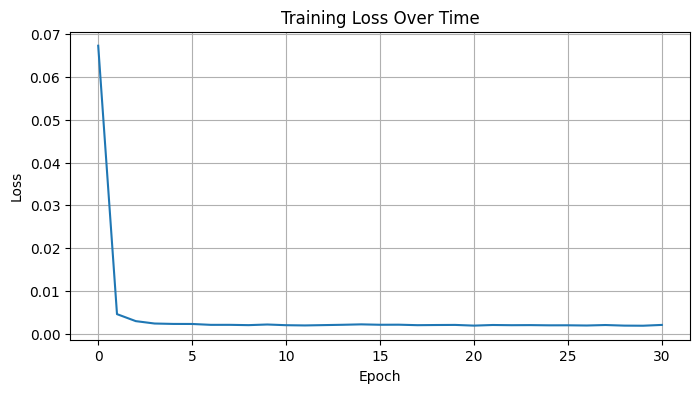

In [55]:
# Create datasets and loaders for 2-hour sequences
print("📦 Creating datasets and loaders...")

train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"📊 Train dataset size: {len(train_dataset)}")
print(f"📊 Test dataset size: {len(test_dataset)}")

# Initialize transformer model for feature-engineered sequences
# Get the number of features from the first sequence
n_features = X_train.shape[2] if len(X_train.shape) == 3 else 15  # fallback to 15 if not 3D
model = SimpleTransformer(input_size=n_features, d_model=64, nhead=4, num_layers=2).to(device)
print(f"✅ Model initialized on {device}")
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# GPU-accelerated training with performance monitoring
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"🚀 Starting GPU-accelerated training on {device}...")

# Training with timing
start_time = time.time()
train_losses = []

for epoch in range(31):
    model.train()
    train_loss = 0
    epoch_start = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to GPU
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader)
    train_losses.append(avg_loss)
    epoch_time = time.time() - epoch_start
    
    if (epoch + 1) % 1== 0: 
        print(f'Epoch {epoch+1:2d}, Loss: {avg_loss:.6f}, Time: {epoch_time:.2f}s')

total_time = time.time() - start_time
print(f"✅ Training completed in {total_time:.2f} seconds")
print(f"Average time per epoch: {total_time/20:.2f} seconds")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


🔍 Making predictions with transformer model...
✅ Predictions completed in 2.4709 seconds
📊 Raw predictions: 1681 samples
📈 Performance Metrics:
  MSE:  4116.166992
  MAE:  51.503838
  RMSE: 64.157364


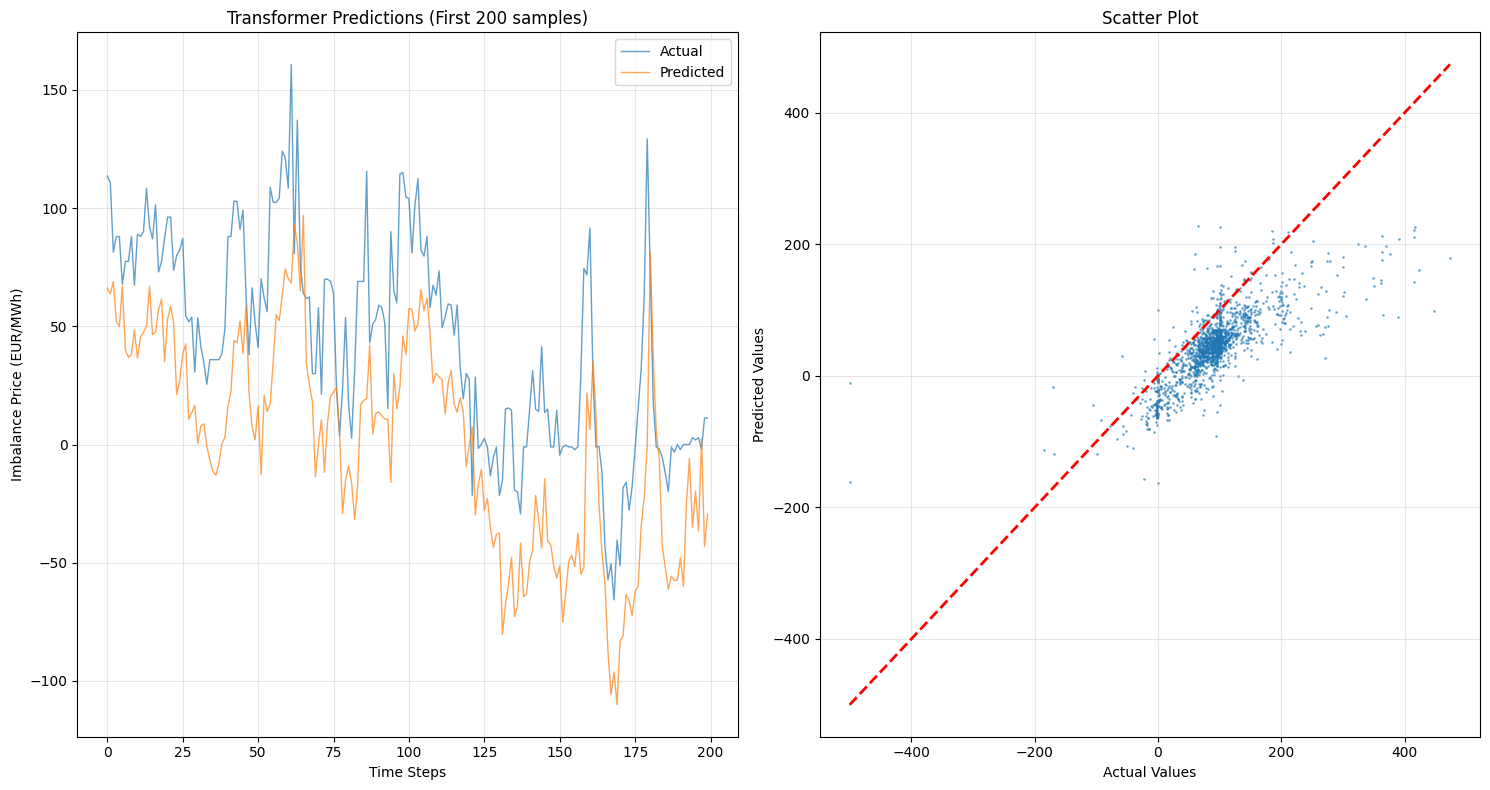

🎉 Transformer model evaluation completed successfully!


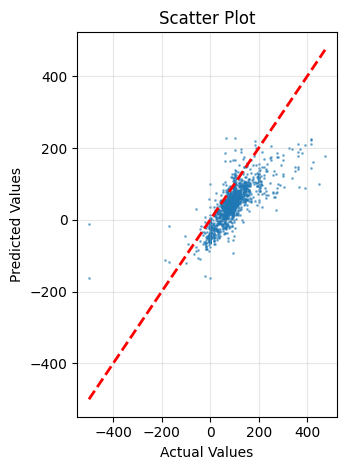

🎉 Transformer model evaluation completed successfully!


In [73]:
# Default evaluation for transformer model
print("🔍 Making predictions with transformer model...")
model.eval()
predictions = []
actuals = []

# Time the prediction process
pred_start = time.time()

with torch.no_grad():
    for data, target in test_loader:
        # Move data to GPU for prediction
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # Move results back to CPU for numpy conversion
        predictions.extend(output.cpu().numpy())
        actuals.extend(target.cpu().numpy())

pred_time = time.time() - pred_start
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

print(f"✅ Predictions completed in {pred_time:.4f} seconds")
print(f"📊 Raw predictions: {len(predictions)} samples")

# Convert back to original scale
predictions_original = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals_original = target_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()

# Calculate performance metrics
mse = np.mean((actuals_original - predictions_original) ** 2)
mae = np.mean(np.abs(actuals_original - predictions_original))
rmse = np.sqrt(mse)

print(f"📈 Performance Metrics:")
print(f"  MSE:  {mse:.6f}")
print(f"  MAE:  {mae:.6f}")
print(f"  RMSE: {rmse:.6f}")

# Plot results
plt.figure(figsize=(15, 8))

# Plot first 200 predictions
plt.subplot(1, 2, 1)
plt.plot(actuals_original[:200], label='Actual', alpha=0.7, linewidth=1)
plt.plot(predictions_original[:200], label='Predicted', alpha=0.7, linewidth=1)
plt.title('Transformer Predictions (First 200 samples)')
plt.xlabel('Time Steps')
plt.ylabel('Imbalance Price (EUR/MWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(actuals_original, predictions_original, alpha=0.5, s=1)
plt.plot([actuals_original.min(), actuals_original.max()], 
         [actuals_original.min(), actuals_original.max()], 'r--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"🎉 Transformer model evaluation completed successfully!")
plt.subplot(1, 2, 2)
plt.scatter(actuals_original, predictions_original, alpha=0.5, s=1)
plt.plot([actuals_original.min(), actuals_original.max()], 
         [actuals_original.min(), actuals_original.max()], 'r--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"🎉 Transformer model evaluation completed successfully!")
